In [153]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [154]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [155]:
### Read in observations ###
directory = "/Users/techadmin/ATMO528/ATSC528/"
filename = "RAOBs_201903131200.txt"
data_str = np.loadtxt("RAOBs_201903131200.txt", delimiter = ',', dtype = str)
# file = open(directory + filename)
# data = file.read()
latitude = data_str[:, 1].astype(float)
longitude = data_str[:, 2].astype(float)
g_h = data_str[:, 3].astype(float)
print(g_h.shape)

#print(latitude)

(135,)


In [156]:
### Set up analysis map with a 22x28 rectangular grid of points ###
phi0 = np.radians(60) #phi naught , 60N
psi0 = np.radians(90)-phi0
lambda0 = -115 #lamda naught, 115W
delx = 1.27 #cm
dely = 1.27 #cm
x0 = 18.90 #cm
y0 = -6.30 #cm 
x_range = np.arange(22)
y_range = np.arange(28)
#print(x_range)
x_calculation = x0 + (delx*x_range) 
y_calculation = y0 + (dely*y_range)
rho = 6371000 #meters
map_scale = 1/15000000 #15 million

x = np.array(x_calculation)
y = np.array(y_calculation)
x_g, y_g = np.meshgrid(x,y)
#print(x_g.shape) 

In [157]:
### convert obs lat/long to x,y ###
x_g_m = x_g/100
y_g_m = y_g/100
print(x_g_m.shape)
numer = (((((x_g_m)/map_scale)**2)+(((y_g_m)/map_scale)**2))**(1/2))
denom = rho*(1+(np.cos(psi0)))
psi = (np.pi/2) - (2*(np.arctan(numer/denom))) #x-cord, y-cord to latitude?
psi = np.degrees(psi)

lamda = (np.degrees(np.arctan(y_g_m/x_g_m)))+lambda0 #x-cord, y-cord to longitude?
# print(lamda)

# print(psi,lamda)
# plt.imshow(lamda)
# plt.colorbar()

(28, 22)


In [158]:
###Making background field
sigma = ((1+np.sin(np.radians(60)))/(1+np.sin(np.radians(latitude))))

x_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.cos(np.radians(longitude)+np.radians(115))) #converting coords to x
y_ob = rho*sigma*(np.cos(np.radians(latitude)))*(np.sin(np.radians(longitude)+np.radians(115))) #converting coords to y
# print(y_ob.shape)
x_ob = x_ob * map_scale *100 #now in cm
y_ob = y_ob * map_scale *100
x_ob_cm = x_ob
y_ob_cm = y_ob
# x_ob = x_ob/100
# y_ob = y_ob/100
print('x_ob', x_ob)
# print('y_ob', y_ob)

for i in range(len(x_ob)):
      # distance_analysis_to_ob = np.sqrt(((x_g_m[i,j]-x_ob)**2)+((y_g_m[i,j]-y_ob)**2))
      distance_ob_to_ob = np.sqrt(((x_ob[i]-x_ob)**2)+((y_ob[i]-y_ob)**2))
      # print("with zero =",len(distance_ob_to_ob))
      distance_ob_to_ob = np.delete(distance_ob_to_ob,i)
      #distance_ob_to_ob = distance_ob_to_ob[distance_ob_to_ob>1e-10] #------------told in class that dmin = avg minimum distance between obs.
      # print("without zero =",len(distance_ob_to_ob))
      #print('distance_ob_to_ob', distance_ob_to_ob)
      #print('distance_ob_to_ob_shape', distance_ob_to_ob.min())

x_g_cm = x_g_m*100
y_g_cm = y_g_m*100
print('x_g_cm',x_g_cm)

Kd = 10.8844524 #cm**2
re = 12.7775892 #cm
fb = np.zeros((28,22))
w = []
for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):
              distance_analysis_to_ob = np.sqrt(((x_g_cm[i,j]-x_ob)**2)+((y_g_cm[i,j]-y_ob)**2))
              dik = distance_analysis_to_ob[distance_analysis_to_ob !=0]
              #dik = dik[dik>R1]
              #print('dik**2',dik**2)
              #w.append(cressman(R1, dik))
              w = np.exp((-dik**2)/Kd)
              #print('w', w)
              #print('w shape', w.shape)
              fb[i,j] = (np.nansum(w*g_h)/np.nansum(w))
              
# print('w', w)
# print('w shape', w.shape)
# print('fb', fb)
# print('fb shape', fb.shape)


x_ob [25.14618727 22.16243723 26.09166841 19.46031159 17.09435424 14.40009368
  6.05286737 14.41403809 12.72077995 16.56021129  3.13233218 22.9844841
 17.86946558 25.02010166  9.98386075 19.32921878 21.19078682 12.33740597
 15.56359807 17.00061122 21.91727344 20.69378516 15.21940721 27.66549619
 18.88775062 25.58945811 40.77215157 31.11193619 18.20292178 29.99626054
 16.61476878 36.03678903 25.4365251  39.95507791 16.68750546 23.93847959
 27.60913213 40.48370863 14.14239876 30.43077713 36.90049707 35.42337811
 33.98640991 47.2983383   9.7434409  27.82000918 36.59335702 21.36278411
 16.71589771 25.13375191 35.32369272 45.62464832 37.51151039 36.47830578
 44.9056349  43.6613456  36.55621593 44.94531637 29.5622763  32.39696588
 43.58871899 42.56808786 14.87917442 36.79320191 40.99223651 35.69700052
 41.03504331 29.92469305 37.45071921 29.65333733 32.9824296  23.96021466
 29.98482233 32.0239038  32.99049755 27.84813015 42.73377124 39.55454532
 37.86100219 37.48060231 38.96822223 34.8793133

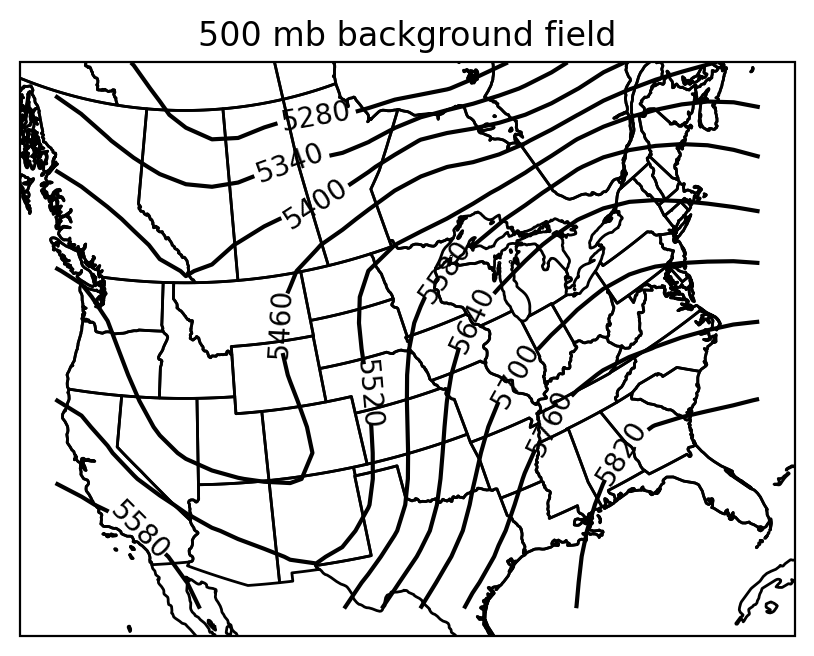

In [159]:
### First analysis, no successive corrections ###
# analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
# print(analysis_1)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(5,5),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fb,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb background field")
plt.show()
# print(fb[-1])

In [160]:
### Analysis
#Perform 3 analyses using
N1 = 2 #(use the 2 closest stations) 
N2 = 4 #(use the 4 closest stations) 
N3 = 10 #(use the 10 closest stations)

# print(distance_ob_to_ob)

def bilienar_interp(x_ob_cm, y_ob_cm):
    # x_k = x_ob*100
    # y_k = y_ob*100
    x_k = x_ob_cm
    y_k = y_ob_cm
    index_x = ((x_k - x0) / delx)
    index_y = ((y_k - y0) / dely)
    # print('index_x', index_x)
    # print('index_y', index_y)
    #flip x,y to j,i because rows then columns in python
    # BLindex_j = int(np.floor(index_x))
    # BLindex_i = int(np.floor(index_y))
    x1 = int(np.floor(index_x))
    y1 = int(np.floor(index_y))
    x2 = int(np.ceil(index_x))
    y2 = int(np.ceil(index_y))
    if ((x1>21) or (x1<0) or (x2>21) or (x2<0) or (y1<0) or (y1>27) or (y2<0) or (y2>27)):
        #print('fuck')

        warr = np.zeros((28,22))
        for i in range(len(x_g_cm)):
            for j in range(len(x_g_cm[i])):
                distance_ob_to_analysis = np.sqrt(((x_ob_cm-x_g[i, j])**2)+((y_ob_cm-y_g[i, j])**2))
                dik = distance_ob_to_analysis
                if distance_ob_to_analysis<re:
                    w = np.exp((-dik**2)/Kd)
                    warr[i, j] = w
        booger = np.sum(warr*fb)/np.sum(warr)
        if np.sum(warr)>0:
            return booger
        else:
            return np.nan

    x1v = x_calculation[x1]
    y1v = y_calculation[y1]
    x2v = x_calculation[x2]
    y2v = y_calculation[y2]


    a_matrix = np.array([[
        1, x1v, y1v, x1v*y1v],
        [1, x1v, y2v, x1v*y2v],
        [1, x2v, y1v, x2v*y1v],
        [1, x2v, y2v, x2v*y2v]])
    
    # print(a_matrix)


    b_matrix = np.array([
                fb.T[x1, y1],
                fb.T[x1, y2],
                fb.T[x2, y1],
                fb.T[x2, y2]])
    

    coef = np.linalg.inv(a_matrix) @ b_matrix

    pt = np.asarray([1,x_ob_cm, y_ob_cm, x_ob_cm * y_ob_cm])

    result = pt@coef

    return result

def correl(s,phi=None,phi_0=None):
    if phi and phi_0:
        b = -1.24 * (1 + np.sin(np.radians(phi))) / (1 + np.sin(np.radians(phi_0)))
    else:
        b = -1.24
    return 0.95*np.exp(b*s**2)

# test = bilienar_interp(x_ob_cm[0], y_ob_cm[0])
# print ('test', test)
# print('fb', fb.shape)
thing2 = np.zeros(135)
for i in range(135):
    thing2[i] = bilienar_interp(x_ob[i], y_ob[i])
# print('thing', thing2)
fb_rk = thing2








# print('x_ob', x_ob)
# for i in range(len(x_ob)):
for i in range(len(x_g_cm)):
        for j in range(len(x_g_cm[i])):
            # distance_ob_to_ob_fix = np.sqrt(((x_ob[i]-x_ob)**2)+((y_ob[i]-y_ob)**2))
            distance_ob_to_ob_fix = np.sqrt(((x_ob[i] -x_ob)**2)+((y_ob[i] -y_ob)**2))

# print('fix', distance_ob_to_ob_fix)
# print('fix', distance_ob_to_ob_fix.shape)


fa_2 = np.zeros(fb.shape)
fa_4 = np.zeros(fb.shape)
fa_10 = np.zeros(fb.shape)

for i in range(len(x_g_cm)):
    for j in range(len(x_g_cm[i])):

        #print('x_g_cm[i,j]', x_g_cm[i,j])
        #print('x_ob', x_ob)
        # print('distance_analysis_to_ob[i]', distance_analysis_to_ob[i])
        dist_obs_to_anal = np.sqrt(((x_g_cm[i, j] -x_ob)**2)+((y_g_cm[i, j] -y_ob)**2))
        # print('dist_obs_to_anal', dist_obs_to_anal.shape)

        closest_2 = np.argsort(dist_obs_to_anal)[:2]
        closest_4 = np.argsort(dist_obs_to_anal)[:4]
        closest_10 = np.argsort(dist_obs_to_anal)[:10]

        dik_2 = dist_obs_to_anal[closest_2]
        dik_4 = dist_obs_to_anal[closest_4]
        dik_10 = dist_obs_to_anal[closest_10]

        x_ob_2 = x_ob[closest_2]
        x_ob_4 = x_ob[closest_4]
        x_ob_10 = x_ob[closest_10]

        y_ob_2 = y_ob[closest_2]
        y_ob_4 = y_ob[closest_4]
        y_ob_10 = y_ob[closest_10]

        obs_inc_2 = g_h[closest_2] - fb_rk[closest_2]
        obs_inc_4 = g_h[closest_4] - fb_rk[closest_4]
        obs_inc_10 = g_h[closest_10] - fb_rk[closest_10]

        rho_ik_2 = correl(dist_obs_to_anal[closest_2]/(map_scale*1E8),40.,60.)
        rho_ik_4 = correl(dist_obs_to_anal[closest_4]/(map_scale*1E8),40.,60.)
        rho_ik_10 = correl(dist_obs_to_anal[closest_10]/(map_scale*1E8),40.,60.)

        rho_kl_2 = np.empty((2,2))
        rho_kl_4 = np.empty((4,4))
        rho_kl_10 = np.empty((10,10))

        for k in range(len(x_ob_2)):
            this_dist = np.sqrt((x_ob_2[k] - x_ob_2)**2 + (y_ob_2[k] - y_ob_2)**2)
            this_dist = this_dist/(map_scale*1E8)
            rho_kl_2[k] = correl(this_dist,40.,60.)
            rho_kl_2[k,k] = 1.0

        for k in range(len(x_ob_4)):
            this_dist = np.sqrt((x_ob_4[k] - x_ob_4)**2 + (y_ob_4[k] - y_ob_4)**2)
            this_dist = this_dist/(map_scale*1E8)
            rho_kl_4[k] = correl(this_dist,40.,60.)
            rho_kl_4[k,k] = 1.0

        for k in range(len(x_ob_10)):
            this_dist = np.sqrt((x_ob_10[k] - x_ob_10)**2 + (y_ob_10[k] - y_ob_10)**2)
            this_dist = this_dist/(map_scale*1E8)
            rho_kl_10[k] = correl(this_dist,40.,60.)
            rho_kl_10[k,k] = 1.0

        A2 = np.matrix(rho_kl_2)
        A4 = np.matrix(rho_kl_4)
        A10 = np.matrix(rho_kl_10)

        B2 = np.matrix(rho_ik_2).T
        B4 = np.matrix(rho_ik_4).T
        B10 = np.matrix(rho_ik_10).T

        w_i = np.array(np.linalg.inv(A2) * B2).flatten()
        w_i2 = np.array(np.linalg.inv(A4) * B4).flatten()
        w_i3 = np.array(np.linalg.inv(A10) * B10).flatten()

        #print(w_i.shape)
        #print(obs_inc_2.shape)

        # print(g_h.shape)
        # print(fb.shape)

        # print(w_i)
        fa_2[i,j] = fb[i,j] + np.sum(w_i*obs_inc_2)
        fa_4[i,j] = fb[i,j] + np.sum(w_i2*obs_inc_4)
        fa_10[i,j] = fb[i,j] + np.sum(w_i3*obs_inc_10)

/var/folders/ph/gnz9scgj5491zgp3rggx75kr0000gp/T/ipykernel_809/1000170039.py:36: RuntimeWarning: invalid value encountered in scalar divide
  booger = np.sum(warr*fb)/np.sum(warr)


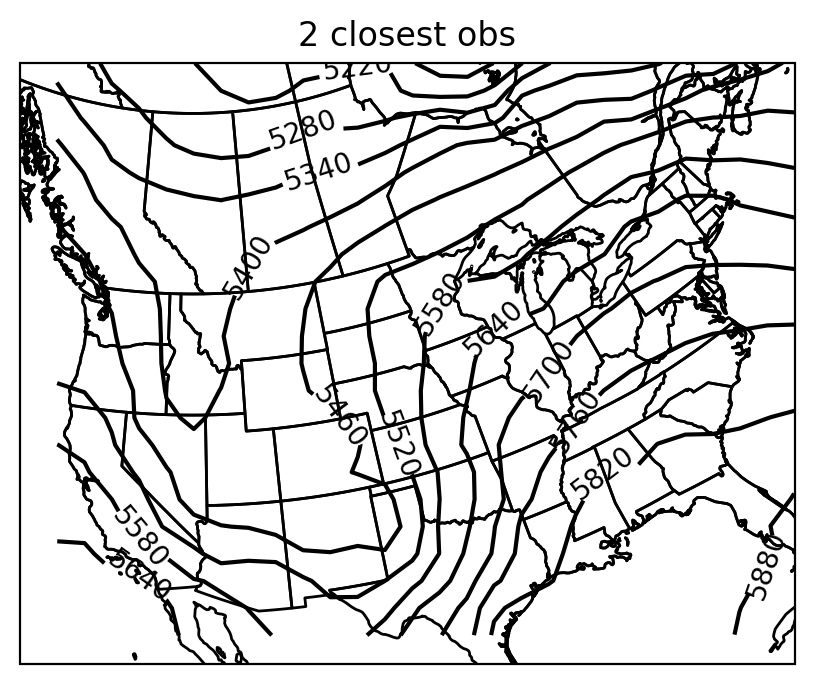

In [161]:
### First analysis, no successive corrections ###
# analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
# print(analysis_1)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(5,5),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fa_2,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("2 closest obs")
plt.show()
# print(fb[-1])

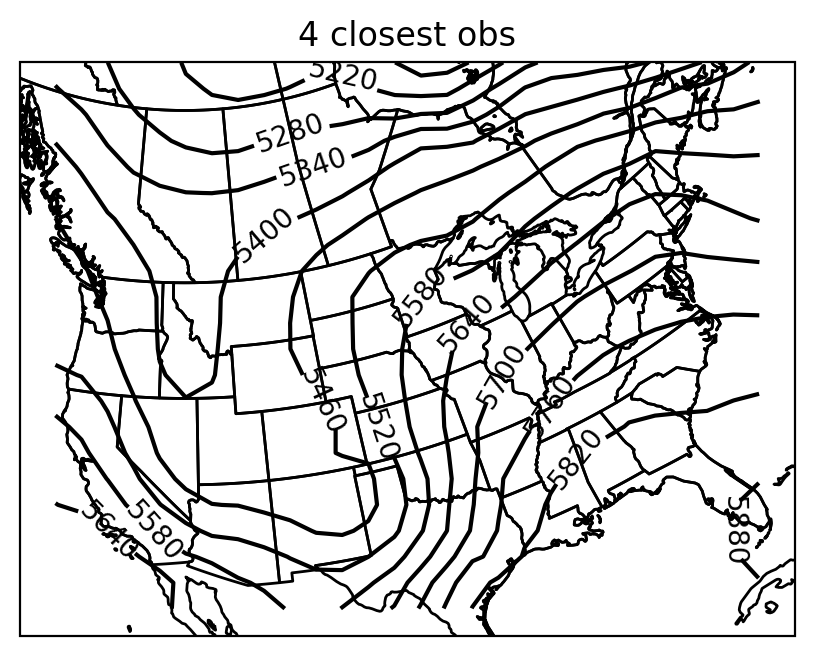

In [162]:
### First analysis, no successive corrections ###
# analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
# print(analysis_1)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(5,5),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fa_4,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("4 closest obs")
plt.show()
# print(fb[-1])

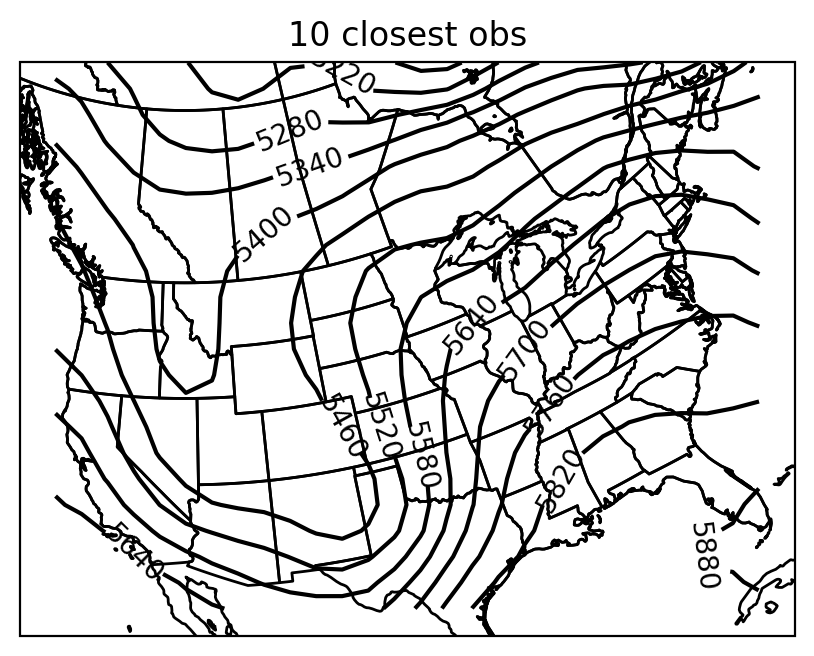

In [163]:
### First analysis, no successive corrections ###
# analysis_1 = np.sum(w*dik*g_h)/(np.sum(w*dik))
# print(analysis_1)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(5,5),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,fa_10,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("10 closest obs")
plt.show()
# print(fb[-1])

In [164]:
### Store the analyses in text files ###
with open('500mb_closest_2.txt','wb') as f:
    for line in fa_2:
        np.savetxt(f, line, fmt='%.2f')

with open('500mb_closest_4.txt','wb') as f:
    for line in fa_4:
        np.savetxt(f, line, fmt='%.2f')

with open('500mb_closest_10.txt','wb') as f:
    for line in fa_10:
        np.savetxt(f, line, fmt='%.2f')

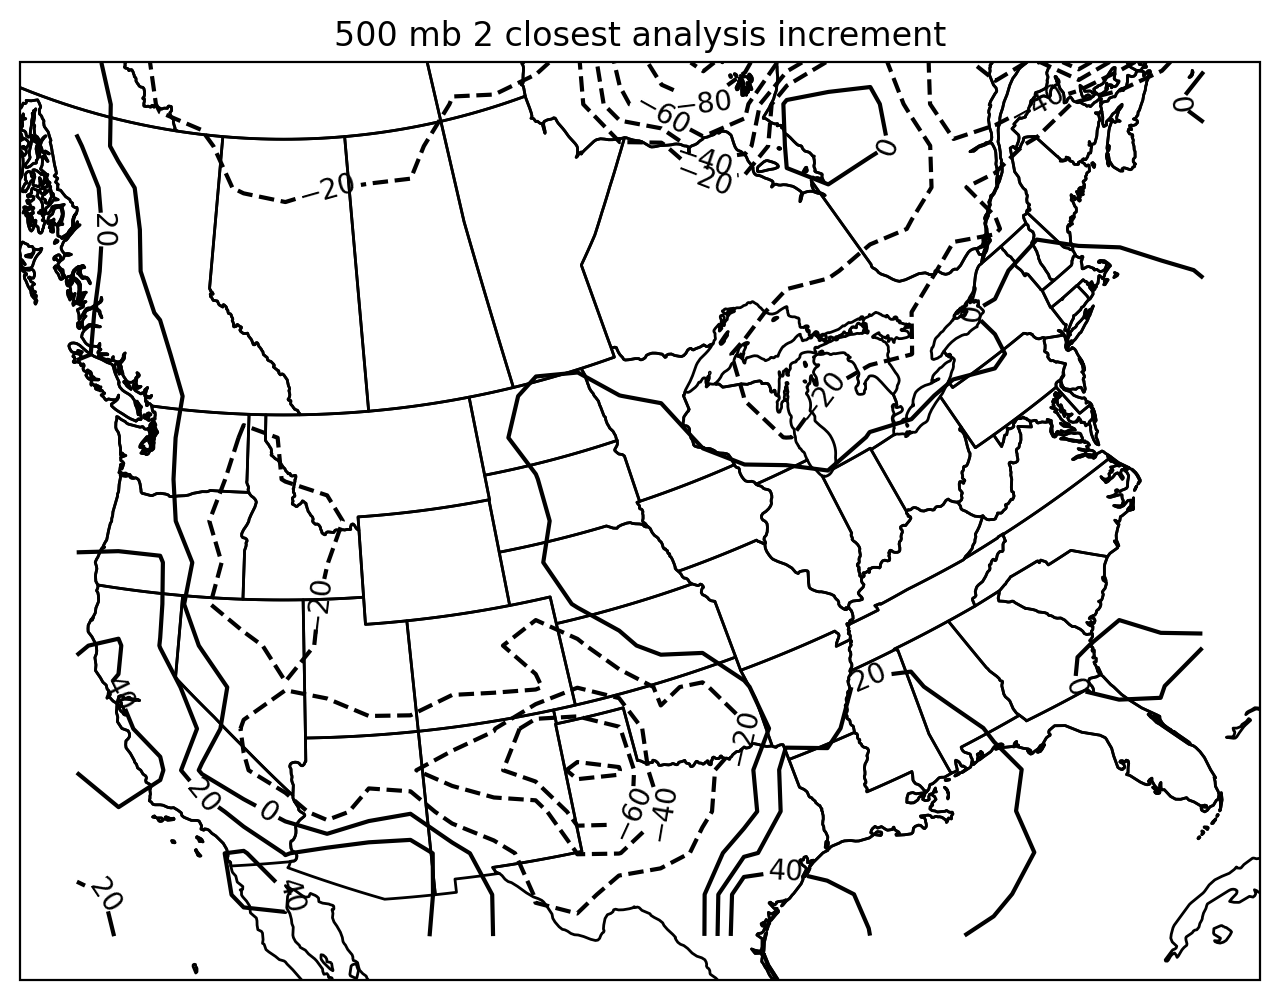

In [165]:
### Calculate Analysis Differences
f_a_diff = fa_2 - fb
#print(f_a_diff)

### Plot Analysis Differences ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,f_a_diff[:,:],colors='k',levels=np.arange(-800,800,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-800,800,20))
plt.title("500 mb 2 closest analysis increment")
plt.show()

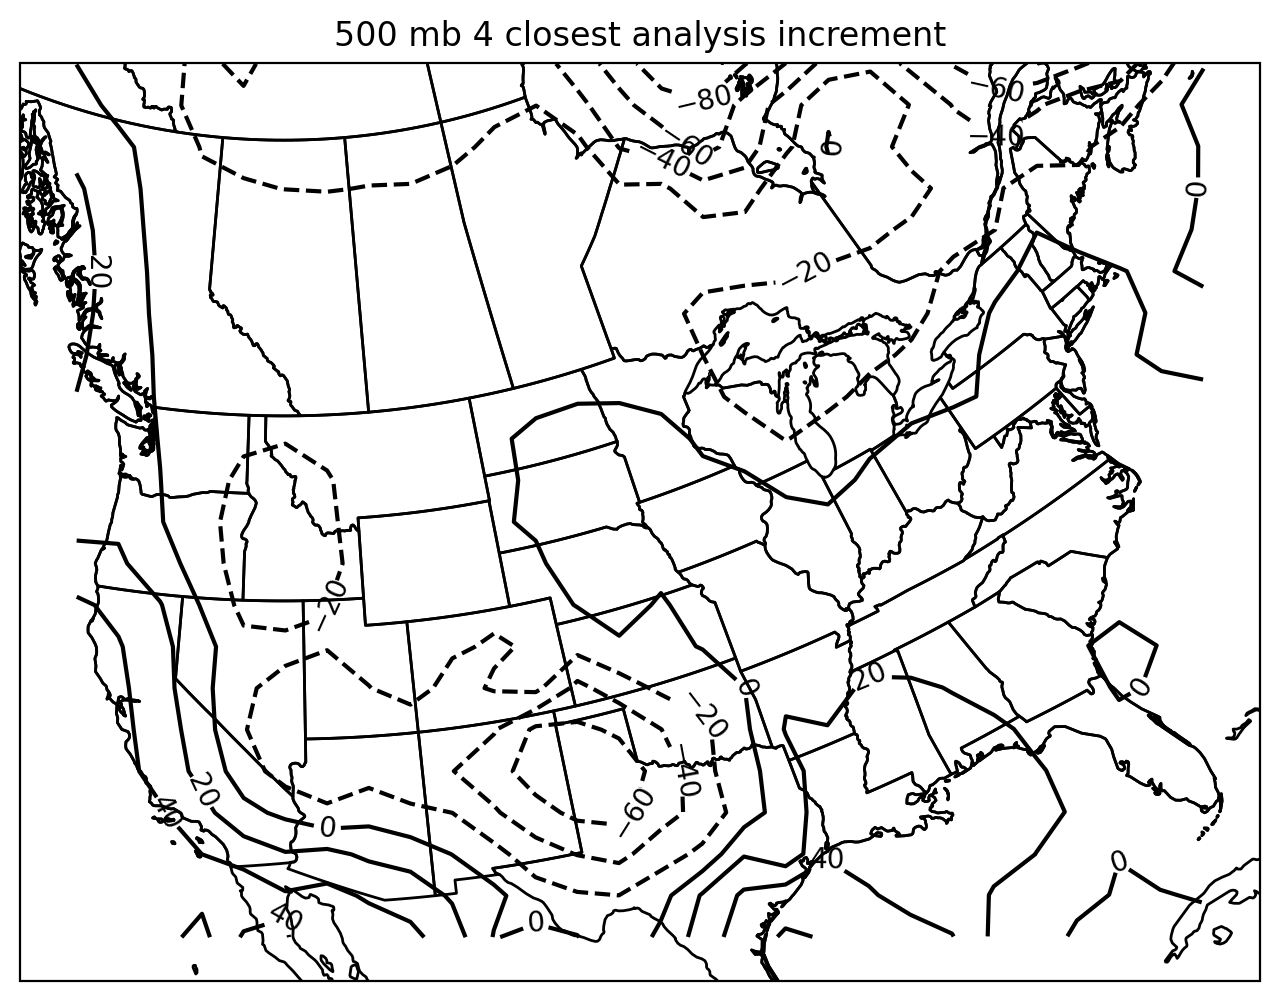

In [166]:
### Calculate Analysis Differences
f_a_diff2 = fa_4 - fb
#print(f_a_diff)

### Plot Analysis Differences ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,f_a_diff2[:,:],colors='k',levels=np.arange(-800,800,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-800,800,20))
plt.title("500 mb 4 closest analysis increment")
plt.show()

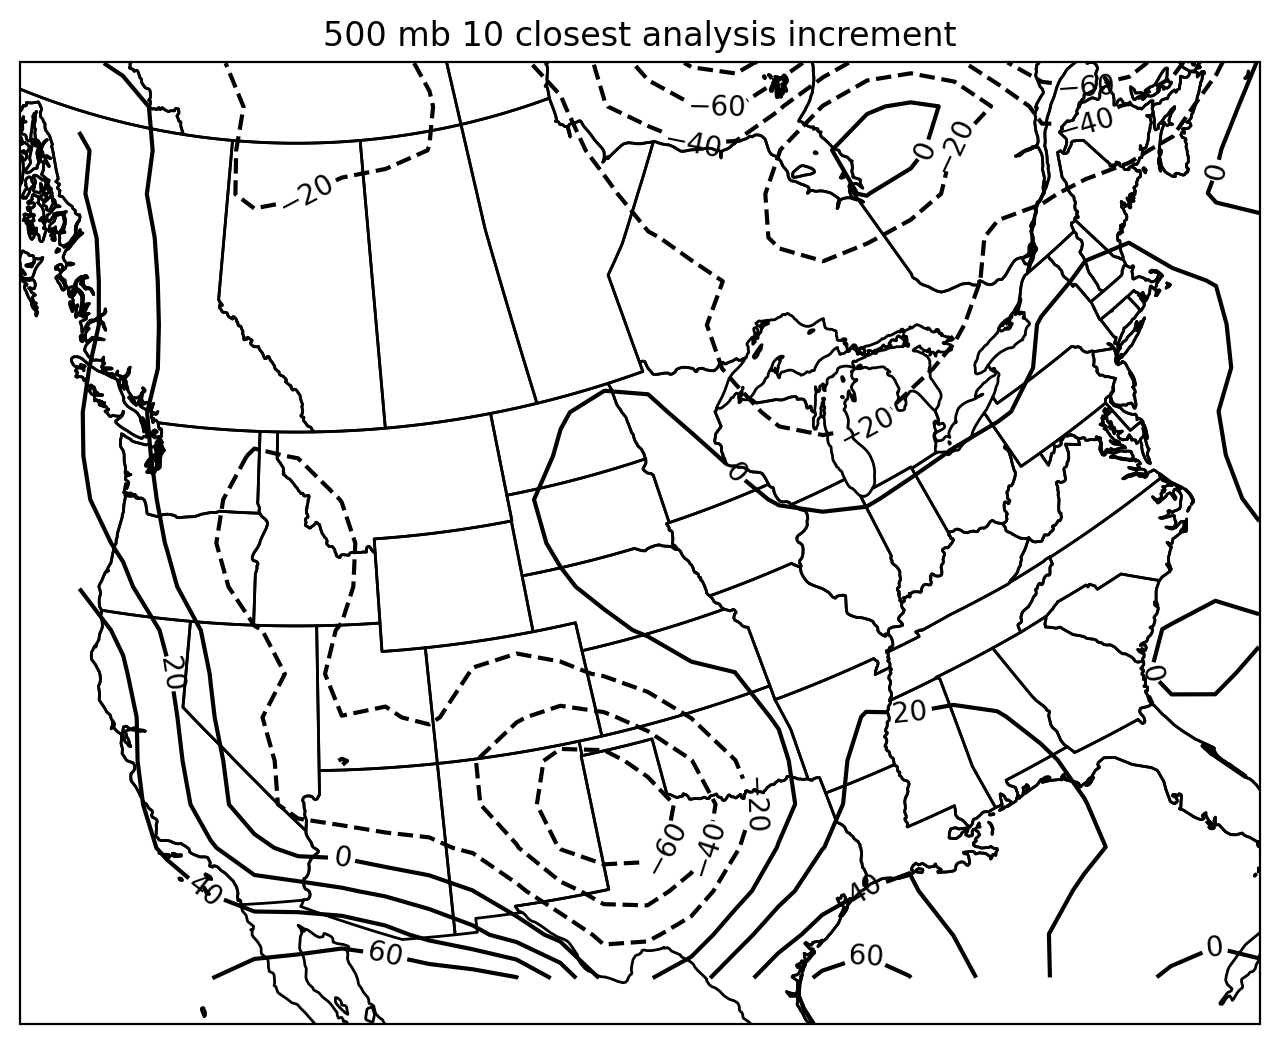

In [167]:
### Calculate Analysis Differences
f_a_diff3 = fa_10 - fb
#print(f_a_diff)

### Plot Analysis Differences ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lamda,psi,f_a_diff3[:,:],colors='k',levels=np.arange(-800,800,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-800,800,20))
plt.title("500 mb 10 closest analysis increment")
plt.show()

In [168]:
### Store the analyses in text files ###
with open('500mb_closest_2_analysis_increment.txt','wb') as f:
    for line in f_a_diff:
        np.savetxt(f, line, fmt='%.2f')

with open('500mb_closest_4_analysis_increment.txt','wb') as f:
    for line in f_a_diff2:
        np.savetxt(f, line, fmt='%.2f')

with open('500mb_closest_10_analysis_increment.txt','wb') as f:
    for line in f_a_diff3:
        np.savetxt(f, line, fmt='%.2f')

In [169]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    
'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n\n3 - What happens as you increase the number of points considered for the analysis?  Is this \n    desirable?  Why or why not?\n    \n'